<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Llama3_2_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip -q install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 91.9 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/Datasets_Weights/LlaMA

hub  token


#Restart the session please!

/root/.cache/huggingface/token

#Must Run This Cell Separately to Set the HF HOME

In [1]:
import os
os.environ['HF_HOME'] = '/content/drive/MyDrive/Datasets_Weights/LlaMA'
hf_home = os.path.expanduser(
    os.getenv("HF_HOME", os.path.join(os.getenv("XDG_CACHE_HOME", "~/.cache"), "huggingface"))
)
print(hf_home)

/content/drive/MyDrive/Datasets_Weights/LlaMA


The secret `HF_TOKEN` does not exist in your Colab secrets.

In [ ]:
from google.colab import userdata
userdata.get('HF_TOKEN')#HF_TOKEN

In [ ]:
import requests
import torch
from torch import nn
from transformers import MllamaForConditionalGeneration, AutoProcessor, MllamaConfig, AutoModelForCausalLM
from typing import List, Optional, Tuple, Union
from PIL import Image
import matplotlib.pyplot as plt

def _prepare_cross_attention_mask(
    cross_attention_mask: torch.Tensor,
    num_vision_tokens: int,
    dtype: str,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # reshape so it can be used by attn module
    batch_size, text_total_length, *_ = cross_attention_mask.shape
    cross_attention_mask = cross_attention_mask.repeat_interleave(num_vision_tokens, dim=3)
    cross_attention_mask = cross_attention_mask.view(batch_size, text_total_length, -1)
    cross_attention_mask = cross_attention_mask.unsqueeze(1)

    # invert the mask
    inverted_cross_attn_mask = (1.0 - cross_attention_mask).to(dtype)
    cross_attention_mask = inverted_cross_attn_mask.masked_fill(
        inverted_cross_attn_mask.to(torch.bool), torch.finfo(dtype).min
    )

    # apply full-row bias, which return 4D tensor of shape [B, H, S1, 1] where value is 0 if the a full row in cross attn mask's
    # last dimension contains negative infinity values, otherwise it's 1
    negative_inf_value = torch.finfo(dtype).min
    full_text_row_masked_out_mask = (
        (cross_attention_mask != negative_inf_value).any(dim=-1).type_as(cross_attention_mask)[..., None]
    )
    cross_attention_mask *= full_text_row_masked_out_mask

    return cross_attention_mask, full_text_row_masked_out_mask
# class Mllama_VLM(AutoModelForCausalLM):
class Mllama_VLM(nn.Module):
    def __init__(self, ):
        super(Mllama_VLM, self).__init__()
        # super().__init__(config)
        model_id = "meta-llama/Llama-3.2-11B-Vision"
        self.model = MllamaForConditionalGeneration.from_pretrained(
            model_id, torch_dtype=torch.bfloat16, device_map="auto",
        )
        self.model.tie_weights()
        self.config = MllamaConfig()
        self.vision_model = self.model.vision_model
        self.language_model = self.model.language_model
        self.multi_modal_projector = self.model.multi_modal_projector
        self.hidden_size = self.config.text_config.hidden_size
        self.dtype = self.model.dtype
        # self.generate = self.model.generate

    def forward(
        self,
        input_ids = None,
        pixel_values = None,
        aspect_ratio_mask = None,
        aspect_ratio_ids = None,
        attention_mask = None,
        cross_attention_mask = None,
        cross_attention_states = None,
        position_ids = None,
        past_key_values = None,
        inputs_embeds = None,
        labels = None,
        use_cache = None,
        output_attentions = None,
        output_hidden_states = None,
        return_dict = None,
        cache_position = None,
        num_logits_to_keep: int = 0,
        ):
        print('pixel_values: Mobarak', pixel_values.shape)
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        # get vision tokens from vision model
        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            aspect_ratio_ids=aspect_ratio_ids,
            aspect_ratio_mask=aspect_ratio_mask,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions,
            return_dict=return_dict,
        )
        cross_attention_states = vision_outputs[0]
        cross_attention_states = self.multi_modal_projector(cross_attention_states).reshape(
            -1, cross_attention_states.shape[-2], self.hidden_size
        )
        if cross_attention_mask is not None:
            cross_attention_mask, full_text_row_masked_out_mask = _prepare_cross_attention_mask(
                cross_attention_mask,
                num_vision_tokens=self.vision_model.num_patches,
                dtype=self.dtype,
            )
        else:
            full_text_row_masked_out_mask = None

        outputs = self.language_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            cross_attention_states=cross_attention_states,
            cross_attention_mask=cross_attention_mask,
            full_text_row_masked_out_mask=full_text_row_masked_out_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            inputs_embeds=inputs_embeds,
            labels=labels,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions,
            return_dict=return_dict,
            cache_position=cache_position,
            num_logits_to_keep=num_logits_to_keep,
        )
        return outputs

def main():
    model_id = "meta-llama/Llama-3.2-11B-Vision"
    processor = AutoProcessor.from_pretrained(model_id)

    url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"
    image = Image.open(requests.get(url, stream=True).raw)
    plt.imshow(image)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = MllamaConfig()
    model = Mllama_VLM()#.to(device)
    # model = Mllama_VLM.from_config(config).to(device)
    # model.tie_weights()
    model.eval()
    print(model.model.device)
    with torch.no_grad():
        prompt = "<|image|><|begin_of_text|>If I had to write a haiku for this one"
        inputs = processor(image, prompt, return_tensors="pt").to(model.model.device)
        # output = model.generate(**inputs, max_new_tokens=30)
        output = model(**inputs)
        # print(len(output[0]))
        # print(len(output[1]))
        print(output)

main()

/usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:1462: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

cpu
pixel_values: Mobarak torch.Size([1, 1, 4, 3, 448, 448])


In [ ]:
import matplotlib.pyplot as plt

model_id = "meta-llama/Llama-3.2-11B-Vision"
processor = AutoProcessor.from_pretrained(model_id)
model = MllamaForConditionalGeneration.from_pretrained(
            model_id, torch_dtype=torch.bfloat16, device_map="auto",
        )

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)

model.eval()
with torch.no_grad():
    prompt = "<|image|><|begin_of_text|>If I had to write a haiku for this one"
    inputs = processor(image, prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_new_tokens=30)
    print(processor.decode(output[0]))

In [ ]:
from transformers import MllamaForConditionalGeneration, AutoProcessor
from transformers import MllamaConfig
configuration = MllamaConfig()
model = MllamaForConditionalGeneration(configuration)
# def get_model(config):
#     model = MllamaForConditionalGeneration(configuration)

# get_model(configuration)

In [ ]:
from typing import List, Optional, Tuple, Union

In [ ]:
/usr/local/lib/python3.10/dist-packages/transformers/models/mllama/modeling_mllama.py

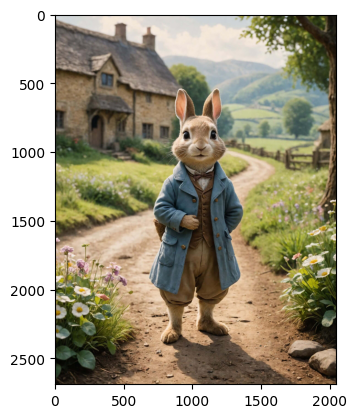

In [ ]:
import matplotlib.pyplot as plt
processor = AutoProcessor.from_pretrained(model_id)
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/0052a70beed5bf71b92610a43a52df6d286cd5f3/diffusers/rabbit.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
prompt = "<|image|><|begin_of_text|>If I had to write a haiku for this one"
inputs = processor(image, prompt, return_tensors="pt").to(model.device)

In [ ]:
for key, value in inputs.items():
    print(key,':', value.shape)

print(inputs['aspect_ratio_ids'], inputs['aspect_ratio_mask'])
plt.subplot(151);plt.axis('OFF'); plt.imshow(inputs['pixel_values'].squeeze()[0].permute(1,2,0).cpu())
plt.subplot(152);plt.axis('OFF'); plt.imshow(inputs['pixel_values'].squeeze()[1].permute(1,2,0).cpu())
plt.subplot(153);plt.axis('OFF'); plt.imshow(inputs['pixel_values'].squeeze()[2].permute(1,2,0).cpu())
plt.subplot(154);plt.axis('OFF'); plt.imshow(inputs['pixel_values'].squeeze()[3].permute(1,2,0).cpu())
plt.subplot(155);plt.axis('OFF'); plt.imshow(image)

NameError: name 'inputs' is not defined

In [ ]:
from transformers import MllamaForConditionalGeneration, AutoProcessor, MllamaConfig
configuration = MllamaConfig()
print(configuration._attn_implementation)
print(configuration.text_config)
# print(configuration.vision_config)

eager
MllamaTextConfig {
  "bos_token_id": 128000,
  "cross_attention_layers": [
    3,
    8,
    13,
    18,
    23,
    28,
    33,
    38
  ],
  "dropout": 0,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "model_type": "mllama_text_model",
  "num_attention_heads": 32,
  "num_hidden_layers": 40,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 500000,
  "tie_word_embeddings": false,
  "transformers_version": "4.45.2",
  "use_cache": true,
  "vocab_size": 128256
}



In [ ]:
model.language_model

MllamaForCausalLM(
  (model): MllamaTextModel(
    (embed_tokens): Embedding(128264, 4096, padding_idx=128004)
    (layers): ModuleList(
      (0-2): 3 x MllamaSelfAttentionDecoderLayer(
        (self_attn): MllamaTextSelfSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MllamaTextMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MllamaTextRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MllamaTextRMSNorm((4096,), eps=1e-05)
     

In [ ]:
model

MllamaForConditionalGeneration(
  (vision_model): MllamaVisionModel(
    (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), padding=valid, bias=False)
    (gated_positional_embedding): MllamaPrecomputedPositionEmbedding(
      (tile_embedding): Embedding(9, 5248000)
    )
    (pre_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (post_tile_positional_embedding): MllamaPrecomputedAspectRatioEmbedding(
      (embedding): Embedding(9, 5120)
    )
    (layernorm_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (layernorm_post): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (transformer): MllamaVisionEncoder(
      (layers): ModuleList(
        (0-31): 32 x MllamaVisionEncoderLayer(
          (self_attn): MllamaVisionSdpaAttention(
            (q_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (k_proj): Linear(in_features=1280, out_features=1280, b